In [1]:
import math

# import import_ipynb
# from utils import df_from_csv, to_be_checked, is_corr_ok, plot_hist, plot_boxes, plot_lines, df_to_csv, drop_pm25_outliers

# with the new api
from importnb import imports
with imports("ipynb"):
    from utils import df_from_csv, to_be_checked, is_corr_ok, plot_hist, plot_boxes, plot_lines, df_to_csv, drop_pm25_outliers

PM2.5: 35.9, AQI: 102
PM2.5: 35.9, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 35.5, Max: 55.4
AQI: 102, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 101, Max: 150


## PM2.5 Clean Data

In [2]:
# Load Raw Data
df_pm25_raw = df_from_csv("pm25_raw.csv")

# Check Data Types
print(df_pm25_raw.dtypes)

df_pm25_raw.head()

TANGARA_260A    float64
TANGARA_4B1A    float64
TANGARA_14D6    float64
TANGARA_2B42    float64
TANGARA_2E9A    float64
TANGARA_2FF6    float64
TANGARA_48C6    float64
TANGARA_F1AE    float64
TANGARA_06BE    float64
dtype: object


,TANGARA_260A,TANGARA_4B1A,TANGARA_14D6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
DATETIME,,,,,,,,,
2023-11-06 00:00:30-05:00,7.0,7.0,19.0,8.0,2.0,8.0,4.0,8.0,9.0
2023-11-06 00:01:00-05:00,6.0,6.0,18.0,8.0,1.0,9.0,6.0,8.0,9.0
2023-11-06 00:01:30-05:00,6.0,5.0,13.0,9.0,1.0,9.0,7.0,7.0,11.0
2023-11-06 00:02:00-05:00,6.0,5.0,11.0,8.0,1.0,8.0,7.0,8.0,11.0
2023-11-06 00:02:30-05:00,7.0,4.0,12.0,9.0,1.0,9.0,5.0,7.0,10.0


## Descriptive Statistics

In [3]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_260A,TANGARA_4B1A,TANGARA_14D6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
count,2179.000000,2156.000000,2121.000000,1979.000000,2159.000000,2149.000000,2058.000000,2172.000000,2138.000000
mean,8.585590,9.454082,8.327204,8.510864,7.948587,8.899953,5.870748,7.755985,11.530870
std,4.917164,16.287277,4.848892,4.742112,8.320428,3.605389,3.800290,6.181154,9.422304
min,3.000000,1.000000,1.000000,2.000000,0.000000,3.000000,0.000000,2.000000,4.000000
25%,5.000000,4.000000,5.000000,6.000000,4.000000,6.000000,3.000000,4.000000,7.000000
50%,7.000000,6.000000,7.000000,7.000000,6.000000,8.000000,5.000000,6.000000,10.000000
75%,12.000000,9.000000,12.000000,9.000000,8.000000,12.000000,7.000000,10.000000,13.000000
max,33.000000,405.000000,26.000000,26.000000,150.000000,27.000000,40.000000,81.000000,102.000000


## Missing Data

In [4]:
# Missing Data Threshold
threshold = 90
print(f'Threshold: {threshold}%')

# For each Tangara sensor
for id_tangara_sensor in df_pm25_raw.columns:
    df_pm25_sensor = df_pm25_raw[[id_tangara_sensor]]
    # To be checked
    is_ok, data_percent, missing_data_percent = to_be_checked(df_pm25_sensor, threshold)
    if not is_ok:
        print(f"Tangara Sensor: {id_tangara_sensor}, Data: {data_percent}%, Missing: {missing_data_percent}%, To be checked")

Threshold: 90%
Tangara Sensor: TANGARA_260A, Data: 76%, Missing: 24%, To be checked
Tangara Sensor: TANGARA_4B1A, Data: 75%, Missing: 25%, To be checked
Tangara Sensor: TANGARA_14D6, Data: 74%, Missing: 26%, To be checked
Tangara Sensor: TANGARA_2B42, Data: 69%, Missing: 31%, To be checked
Tangara Sensor: TANGARA_2E9A, Data: 75%, Missing: 25%, To be checked
Tangara Sensor: TANGARA_2FF6, Data: 75%, Missing: 25%, To be checked
Tangara Sensor: TANGARA_48C6, Data: 72%, Missing: 28%, To be checked
Tangara Sensor: TANGARA_F1AE, Data: 75%, Missing: 25%, To be checked
Tangara Sensor: TANGARA_06BE, Data: 74%, Missing: 26%, To be checked


/home/sebaxtian/Workspaces/Tangara/tangara-pipeline/standalone/notebooks/utils.ipynb:197: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  missing_data_percent = round(df_sensor.isna().sum()[0] * 100 / total)
/home/sebaxtian/Workspaces/Tangara/tangara-pipeline/standalone/notebooks/utils.ipynb:198: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_percent = round(df_sensor.count()[0] * 100 / total)
/home/sebaxtian/Workspaces/Tangara/tangara-pipeline/standalone/notebooks/utils.ipynb:197: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

## Data Correlation

In [5]:
# Data Correlation Threshold
threshold = 0.9
print(f'Threshold: {threshold}%')

ID_REFE_TANGARA_SENSOR='TANGARA_06BE'
ID_TARG_TANGARA_SENSOR='TANGARA_2FF6'
# Reference Tangara Sensor
df_reference_sensor = df_pm25_raw[ID_REFE_TANGARA_SENSOR]
# Target Tangara Sensor
df_target_sensor = df_pm25_raw[ID_TARG_TANGARA_SENSOR]

# To be checked
if not math.isnan(df_reference_sensor.std()):
    is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
    if not is_ok:
        print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {ID_TARG_TANGARA_SENSOR}, Correlation: {corr}, To be checked")

# For each Tangara sensor
# for id_tangara_sensor in df_pm25_raw.columns:
#     # Target Tangara Sensor
#     df_target_sensor = df_pm25_raw[id_tangara_sensor]
#     # To be checked
#     is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
#     if not is_ok:
#         print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {id_tangara_sensor}, Correlation: {corr}, To be checked")

Threshold: 0.9%
Reference Tangara Sensor: TANGARA_06BE, Target Tangara Sensor: TANGARA_2FF6, Correlation: 0.0, To be checked


## Histograms

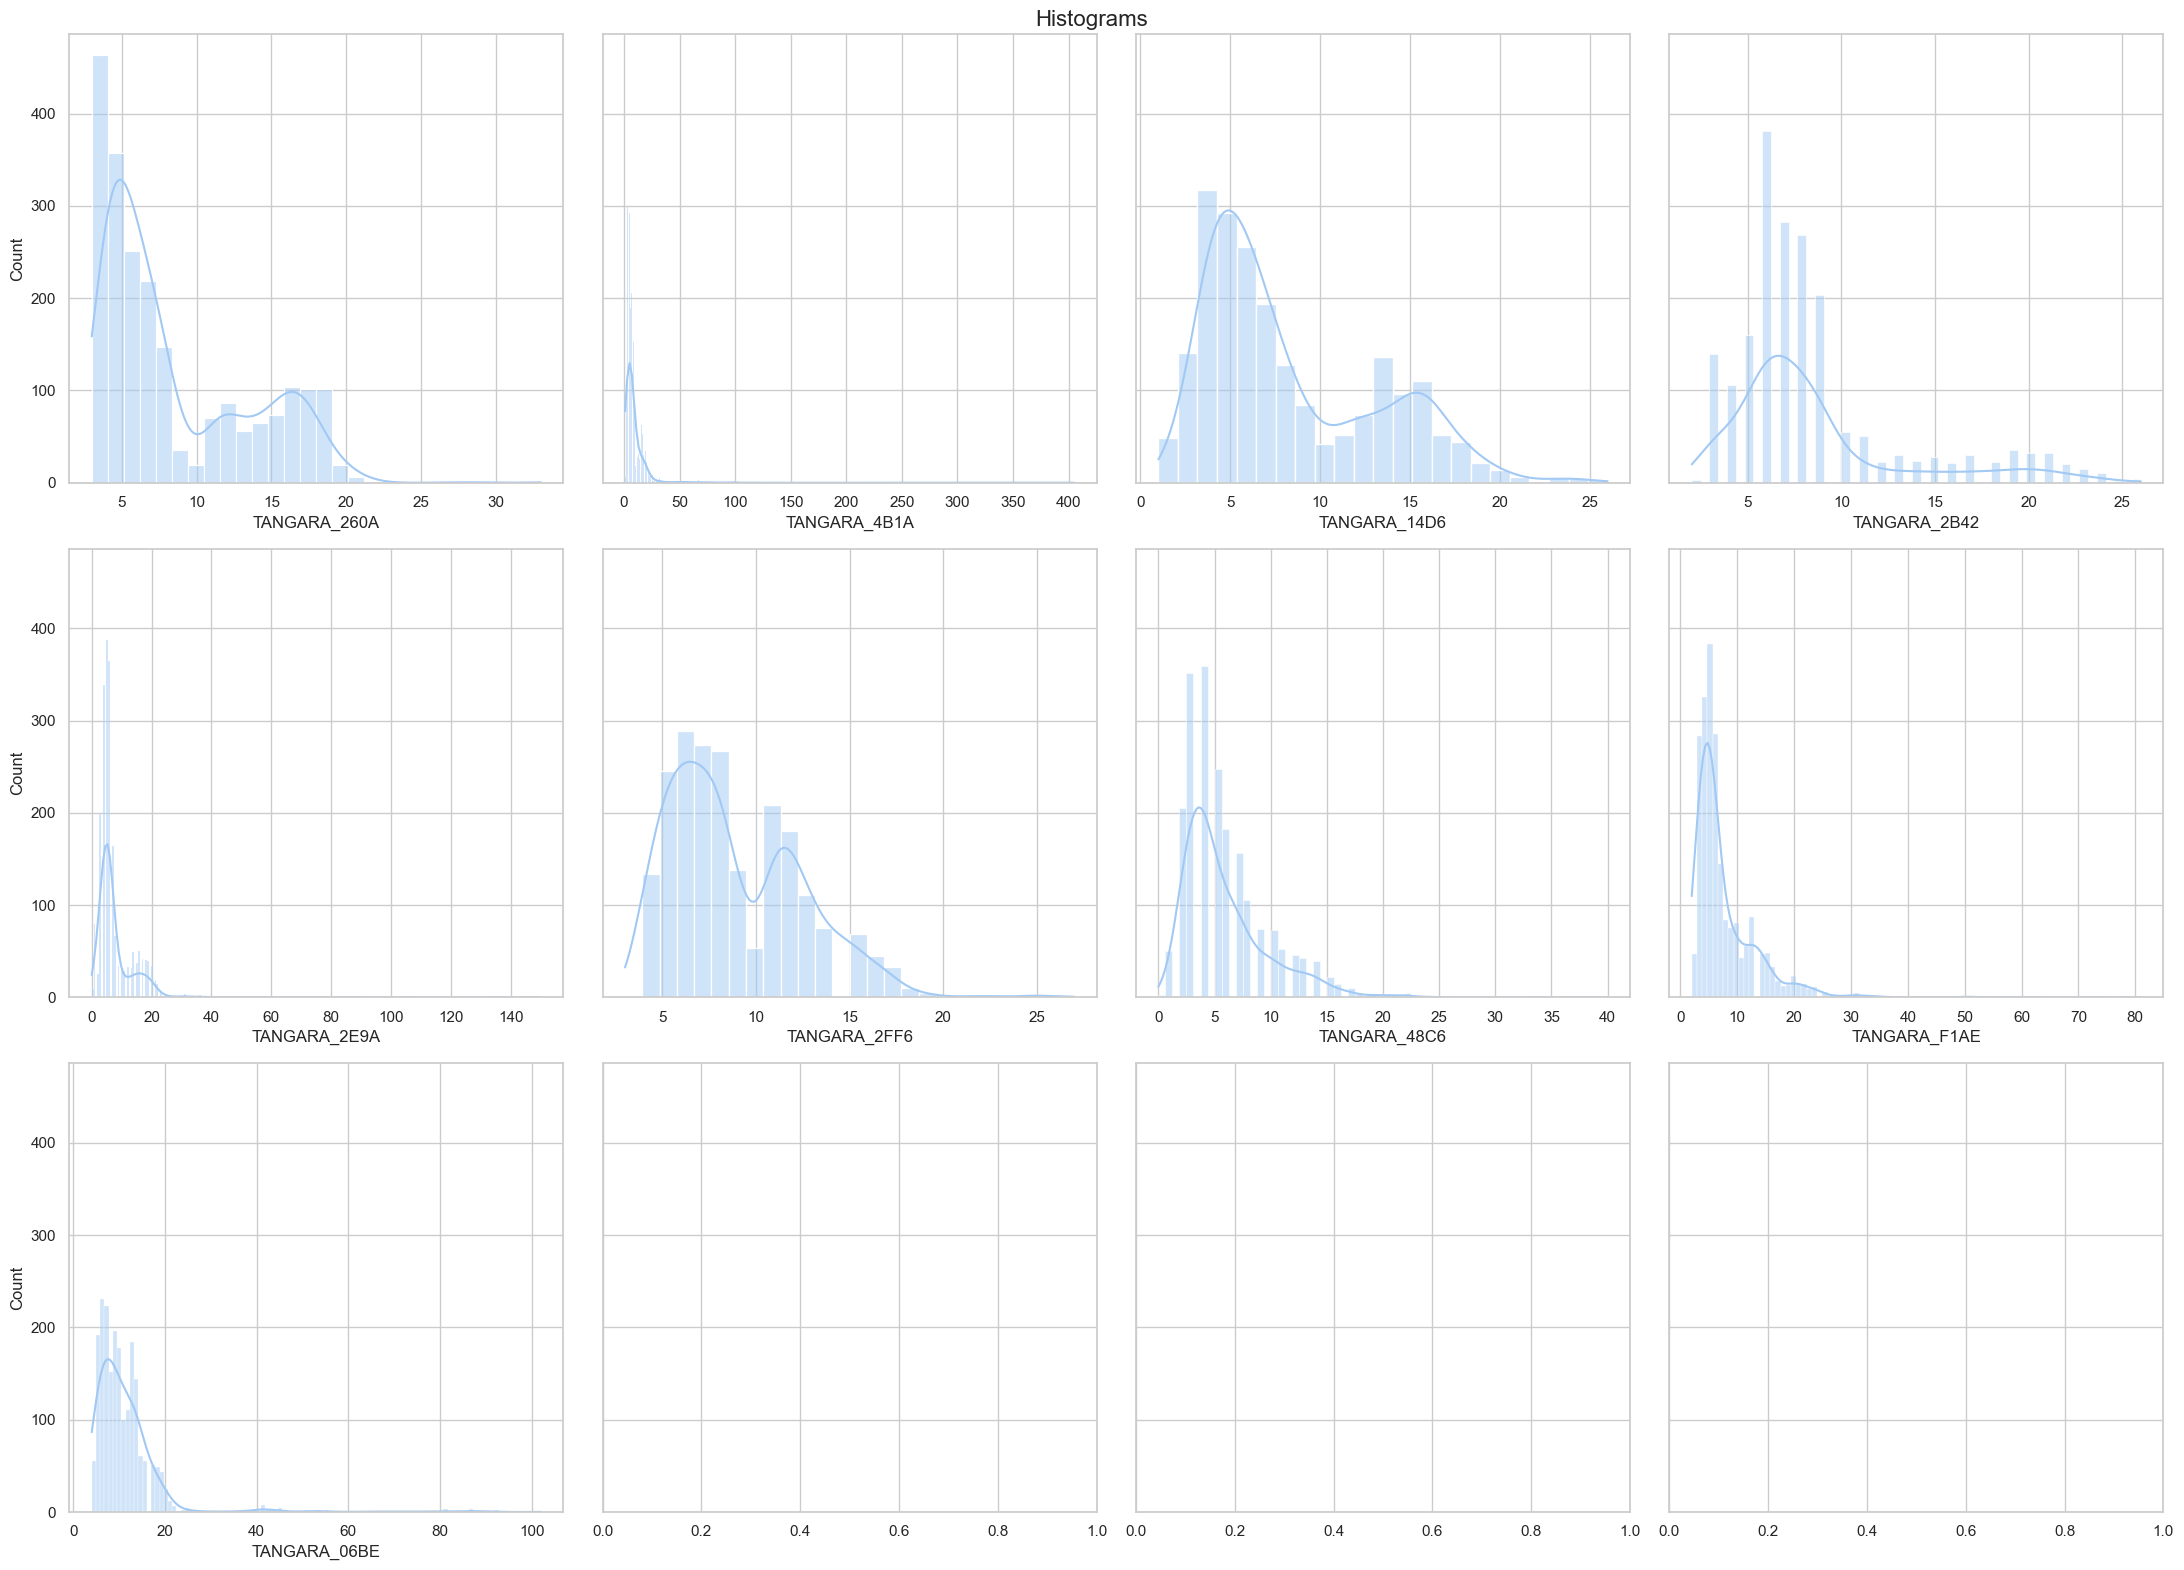

In [6]:
# Plot Histograms
plot_hist(df_pm25_raw)

## Boxplots

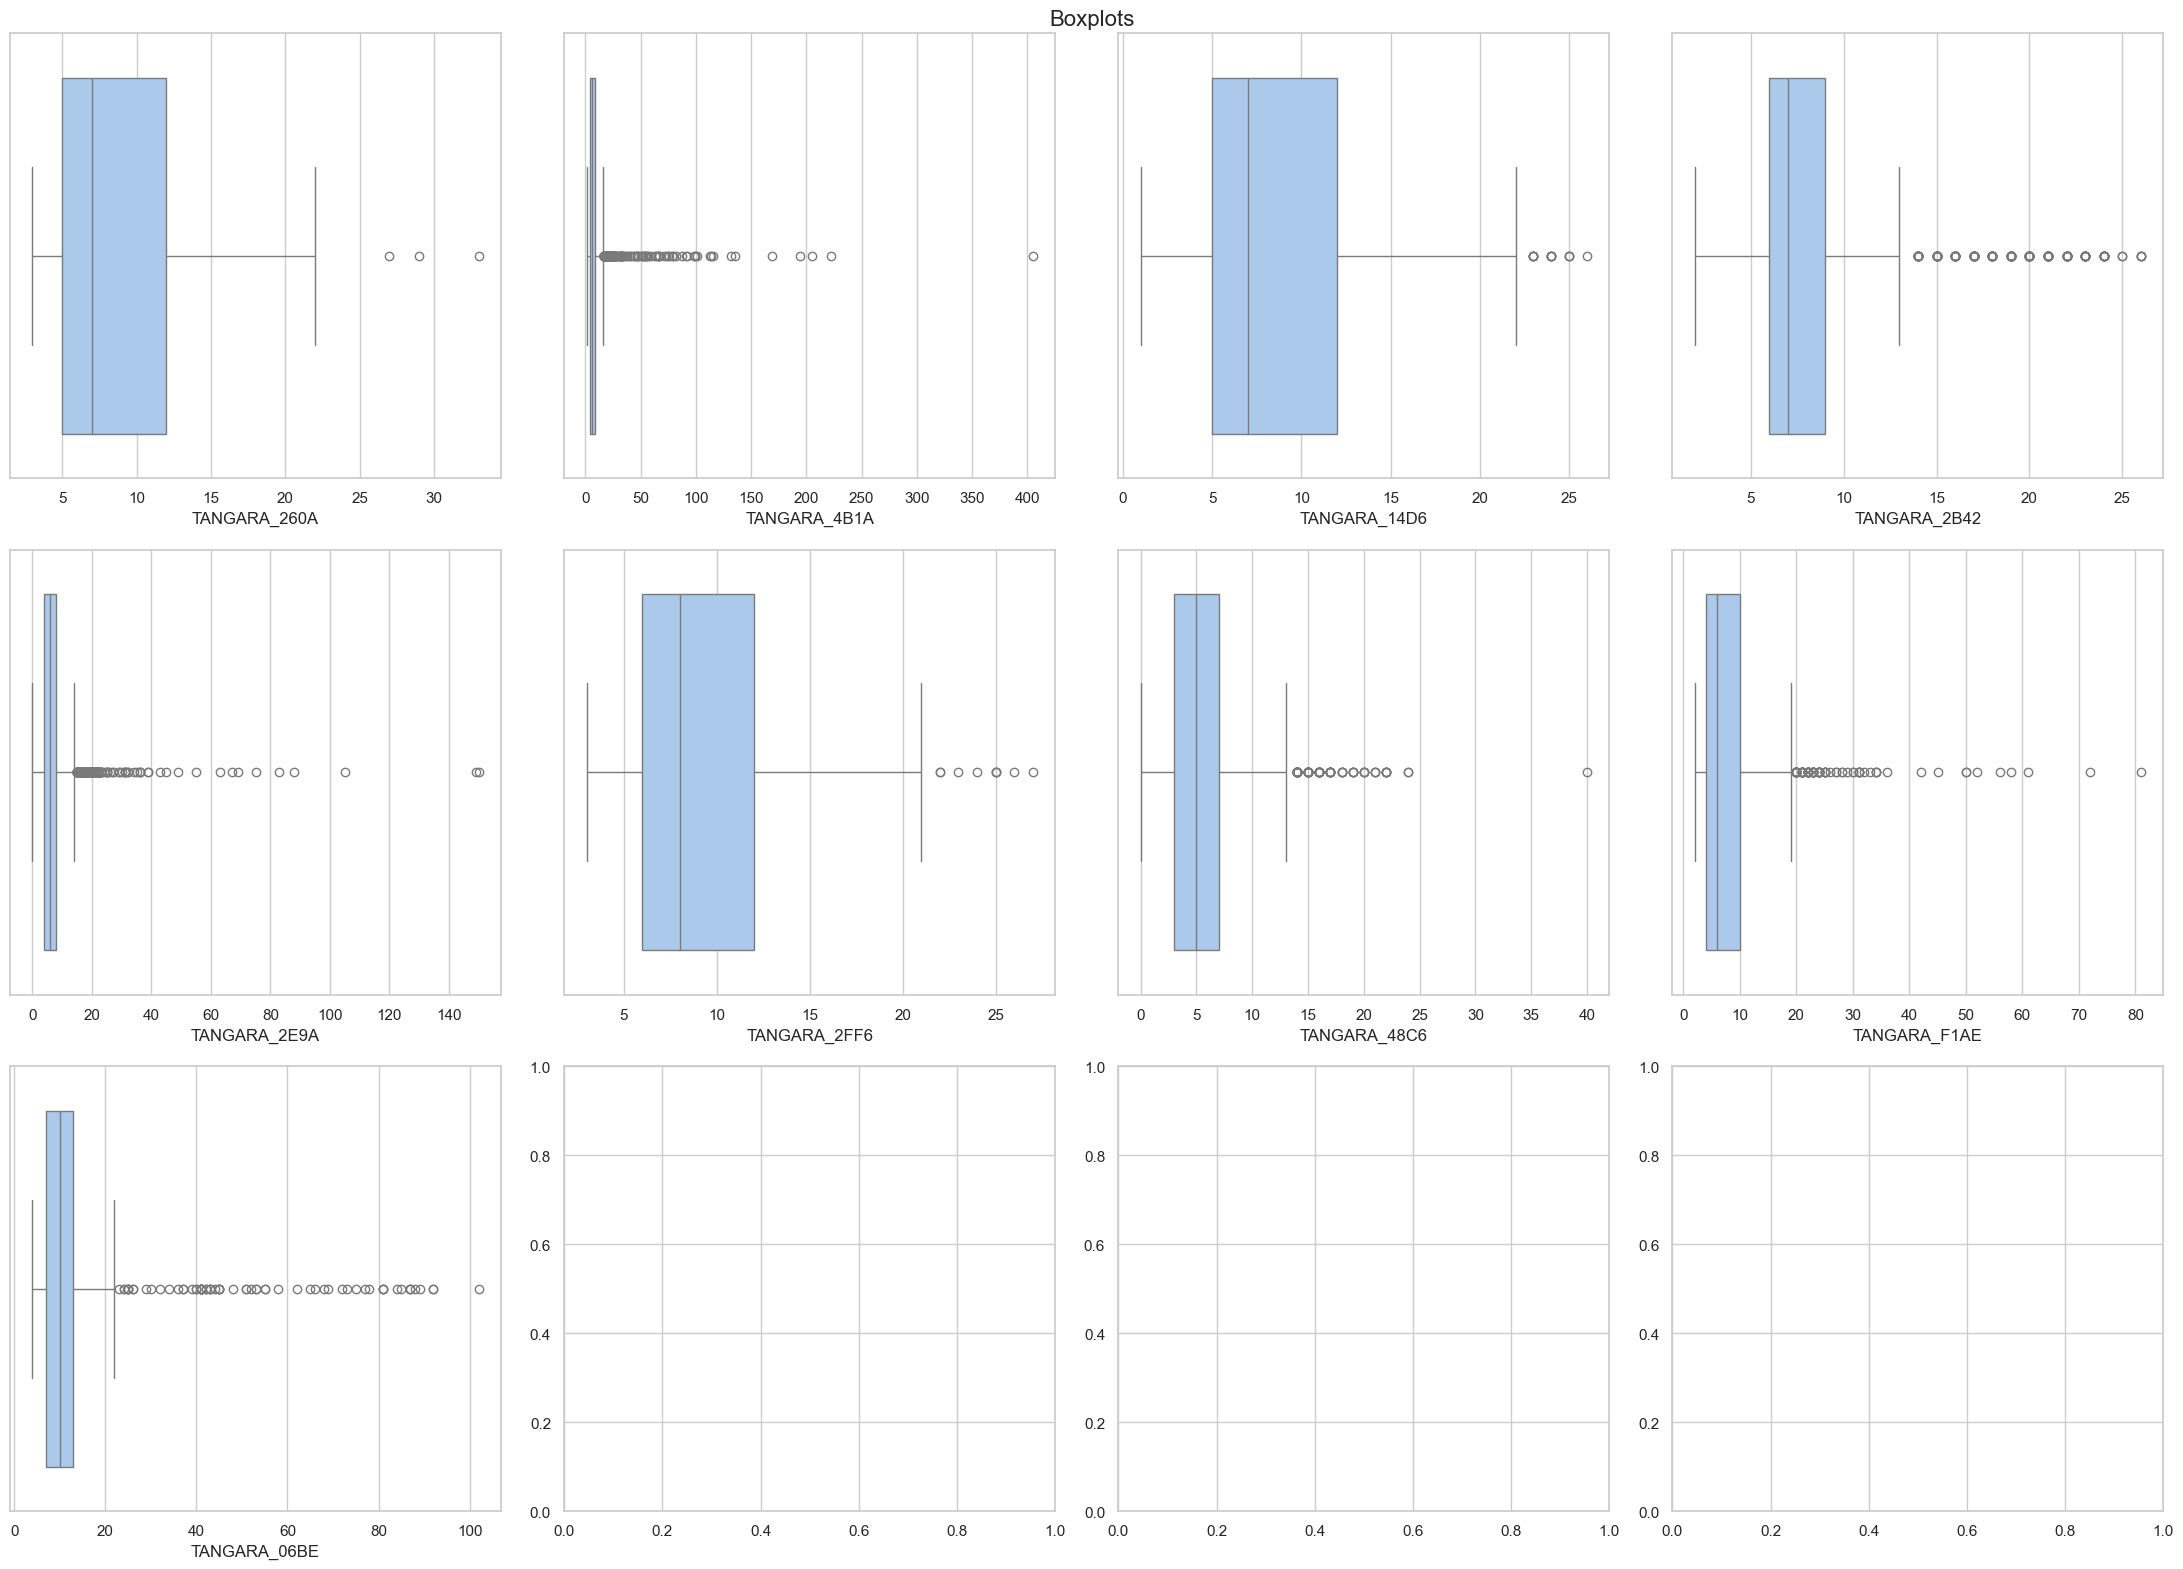

In [7]:
# Plot Boxplots
plot_boxes(df_pm25_raw)

## Lineplots

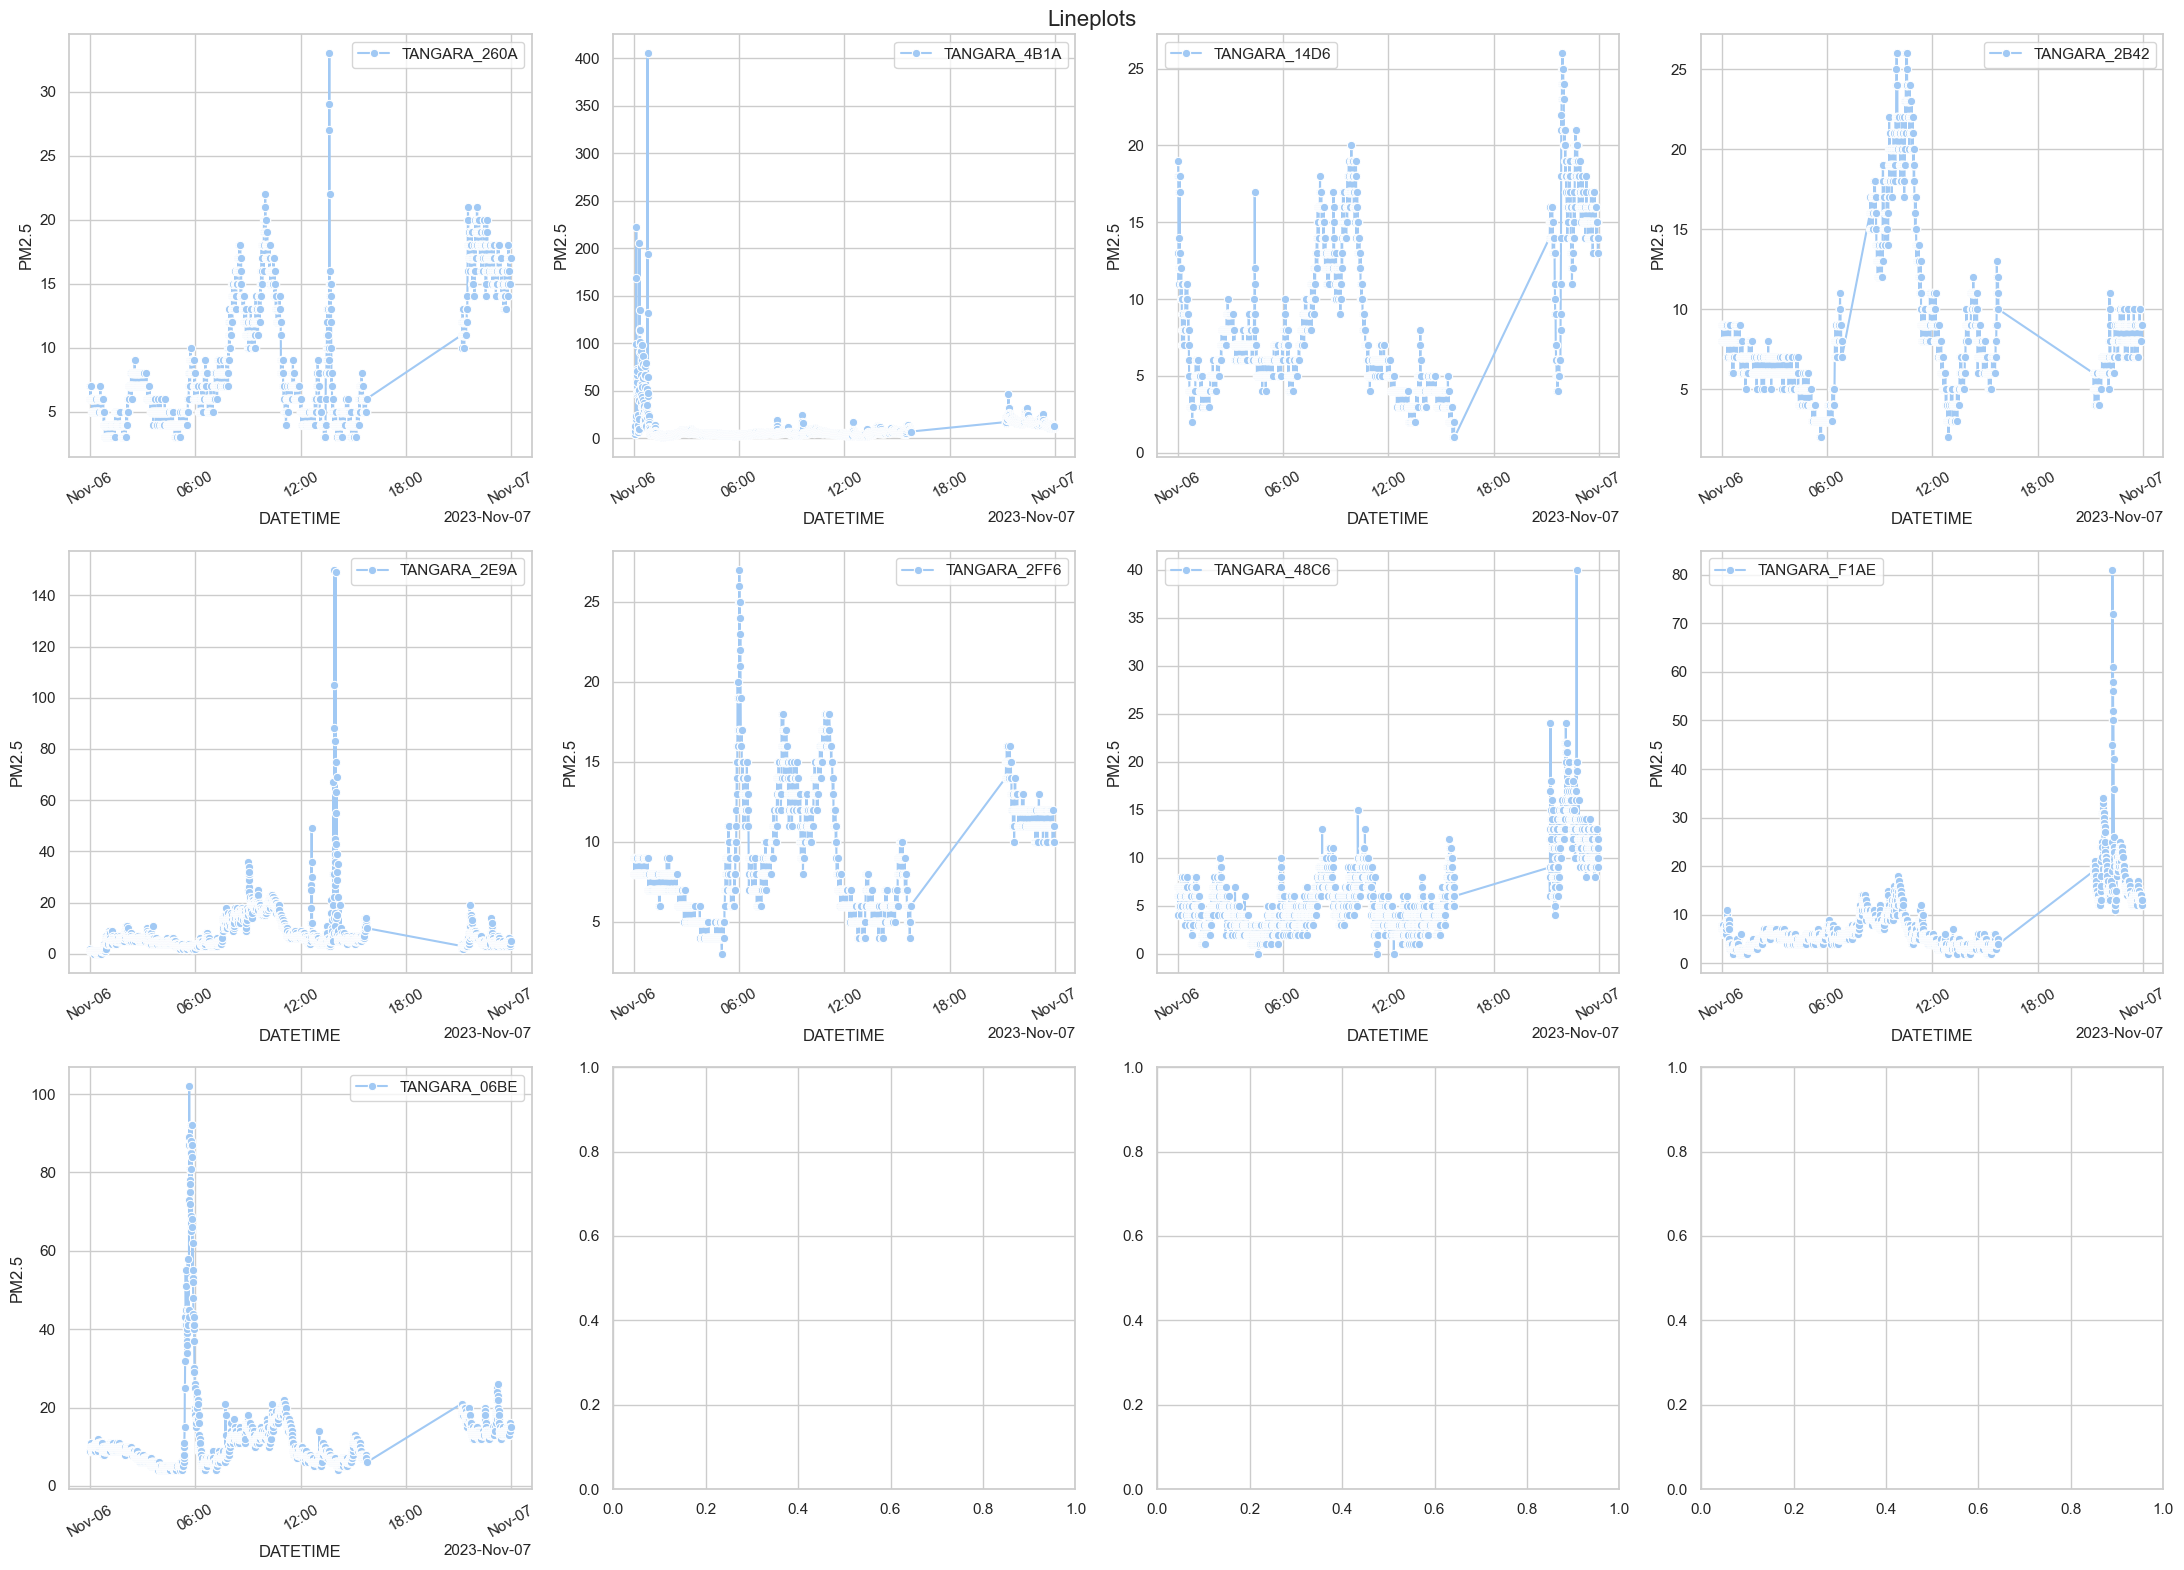

In [8]:
# Plot Lineplots
plot_lines(df_pm25_raw)

## Drop PM2.5 Outliers

In [9]:
# Drop PM2.5 Outliers
df_pm25_clean, resume = drop_pm25_outliers(df_pm25_raw)

In [10]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_260A,TANGARA_4B1A,TANGARA_14D6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
count,2176.000000,1893.000000,2107.000000,1703.000000,1840.00000,2140.000000,1949.000000,2065.000000,2069.000000
mean,8.556526,6.117802,8.223066,6.849677,5.60163,8.835047,5.288353,6.775303,10.146931
std,4.856897,3.363679,4.692397,2.207976,2.74025,3.469278,2.863416,3.802650,4.133257
min,3.000000,1.000000,1.000000,2.000000,0.00000,3.000000,0.000000,2.000000,4.000000
25%,5.000000,4.000000,5.000000,6.000000,4.00000,6.000000,3.000000,4.000000,7.000000
50%,7.000000,5.000000,6.000000,7.000000,5.00000,8.000000,5.000000,5.000000,9.000000
75%,12.000000,7.000000,12.000000,8.000000,6.00000,11.000000,7.000000,8.000000,13.000000
max,22.000000,16.000000,22.000000,13.000000,14.00000,21.000000,13.000000,19.000000,22.000000


In [11]:
# Describe Data
df_pm25_clean.describe()

,TANGARA_260A,TANGARA_4B1A,TANGARA_14D6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
count,2176.000000,1893.000000,2107.000000,1703.000000,1840.00000,2140.000000,1949.000000,2065.000000,2069.000000
mean,8.556526,6.117802,8.223066,6.849677,5.60163,8.835047,5.288353,6.775303,10.146931
std,4.856897,3.363679,4.692397,2.207976,2.74025,3.469278,2.863416,3.802650,4.133257
min,3.000000,1.000000,1.000000,2.000000,0.00000,3.000000,0.000000,2.000000,4.000000
25%,5.000000,4.000000,5.000000,6.000000,4.00000,6.000000,3.000000,4.000000,7.000000
50%,7.000000,5.000000,6.000000,7.000000,5.00000,8.000000,5.000000,5.000000,9.000000
75%,12.000000,7.000000,12.000000,8.000000,6.00000,11.000000,7.000000,8.000000,13.000000
max,22.000000,16.000000,22.000000,13.000000,14.00000,21.000000,13.000000,19.000000,22.000000


## Histograms

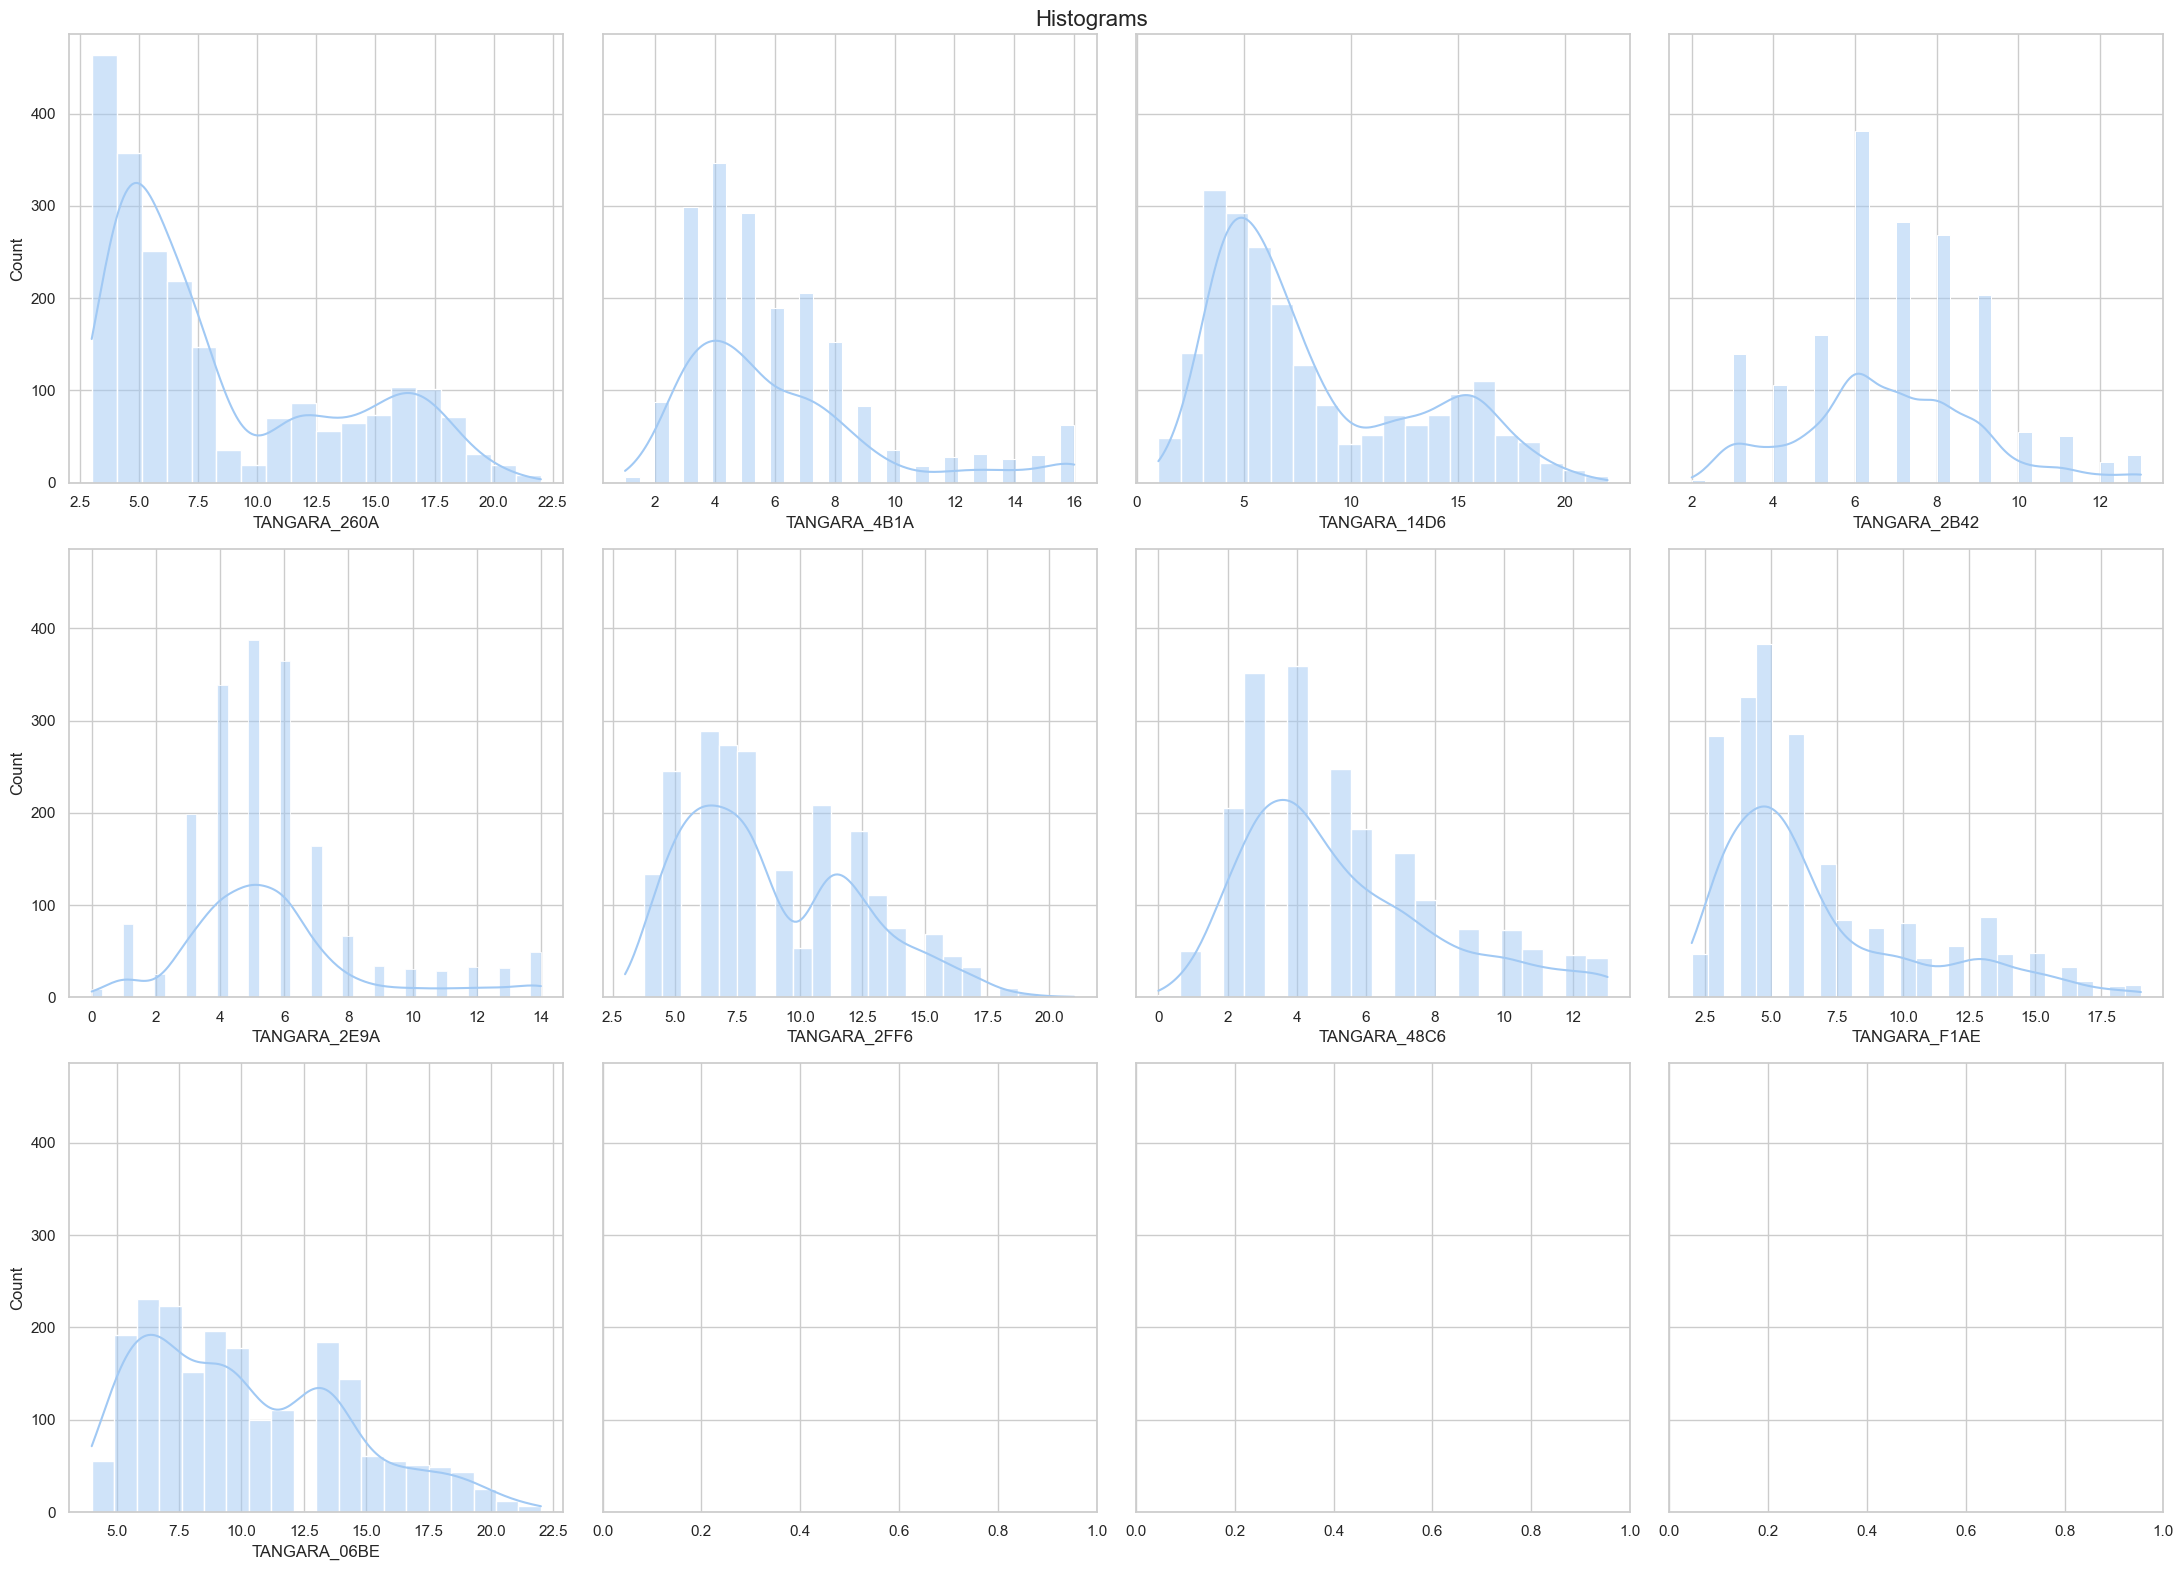

In [12]:
# Plot Histograms
plot_hist(df_pm25_clean)

## Boxplots

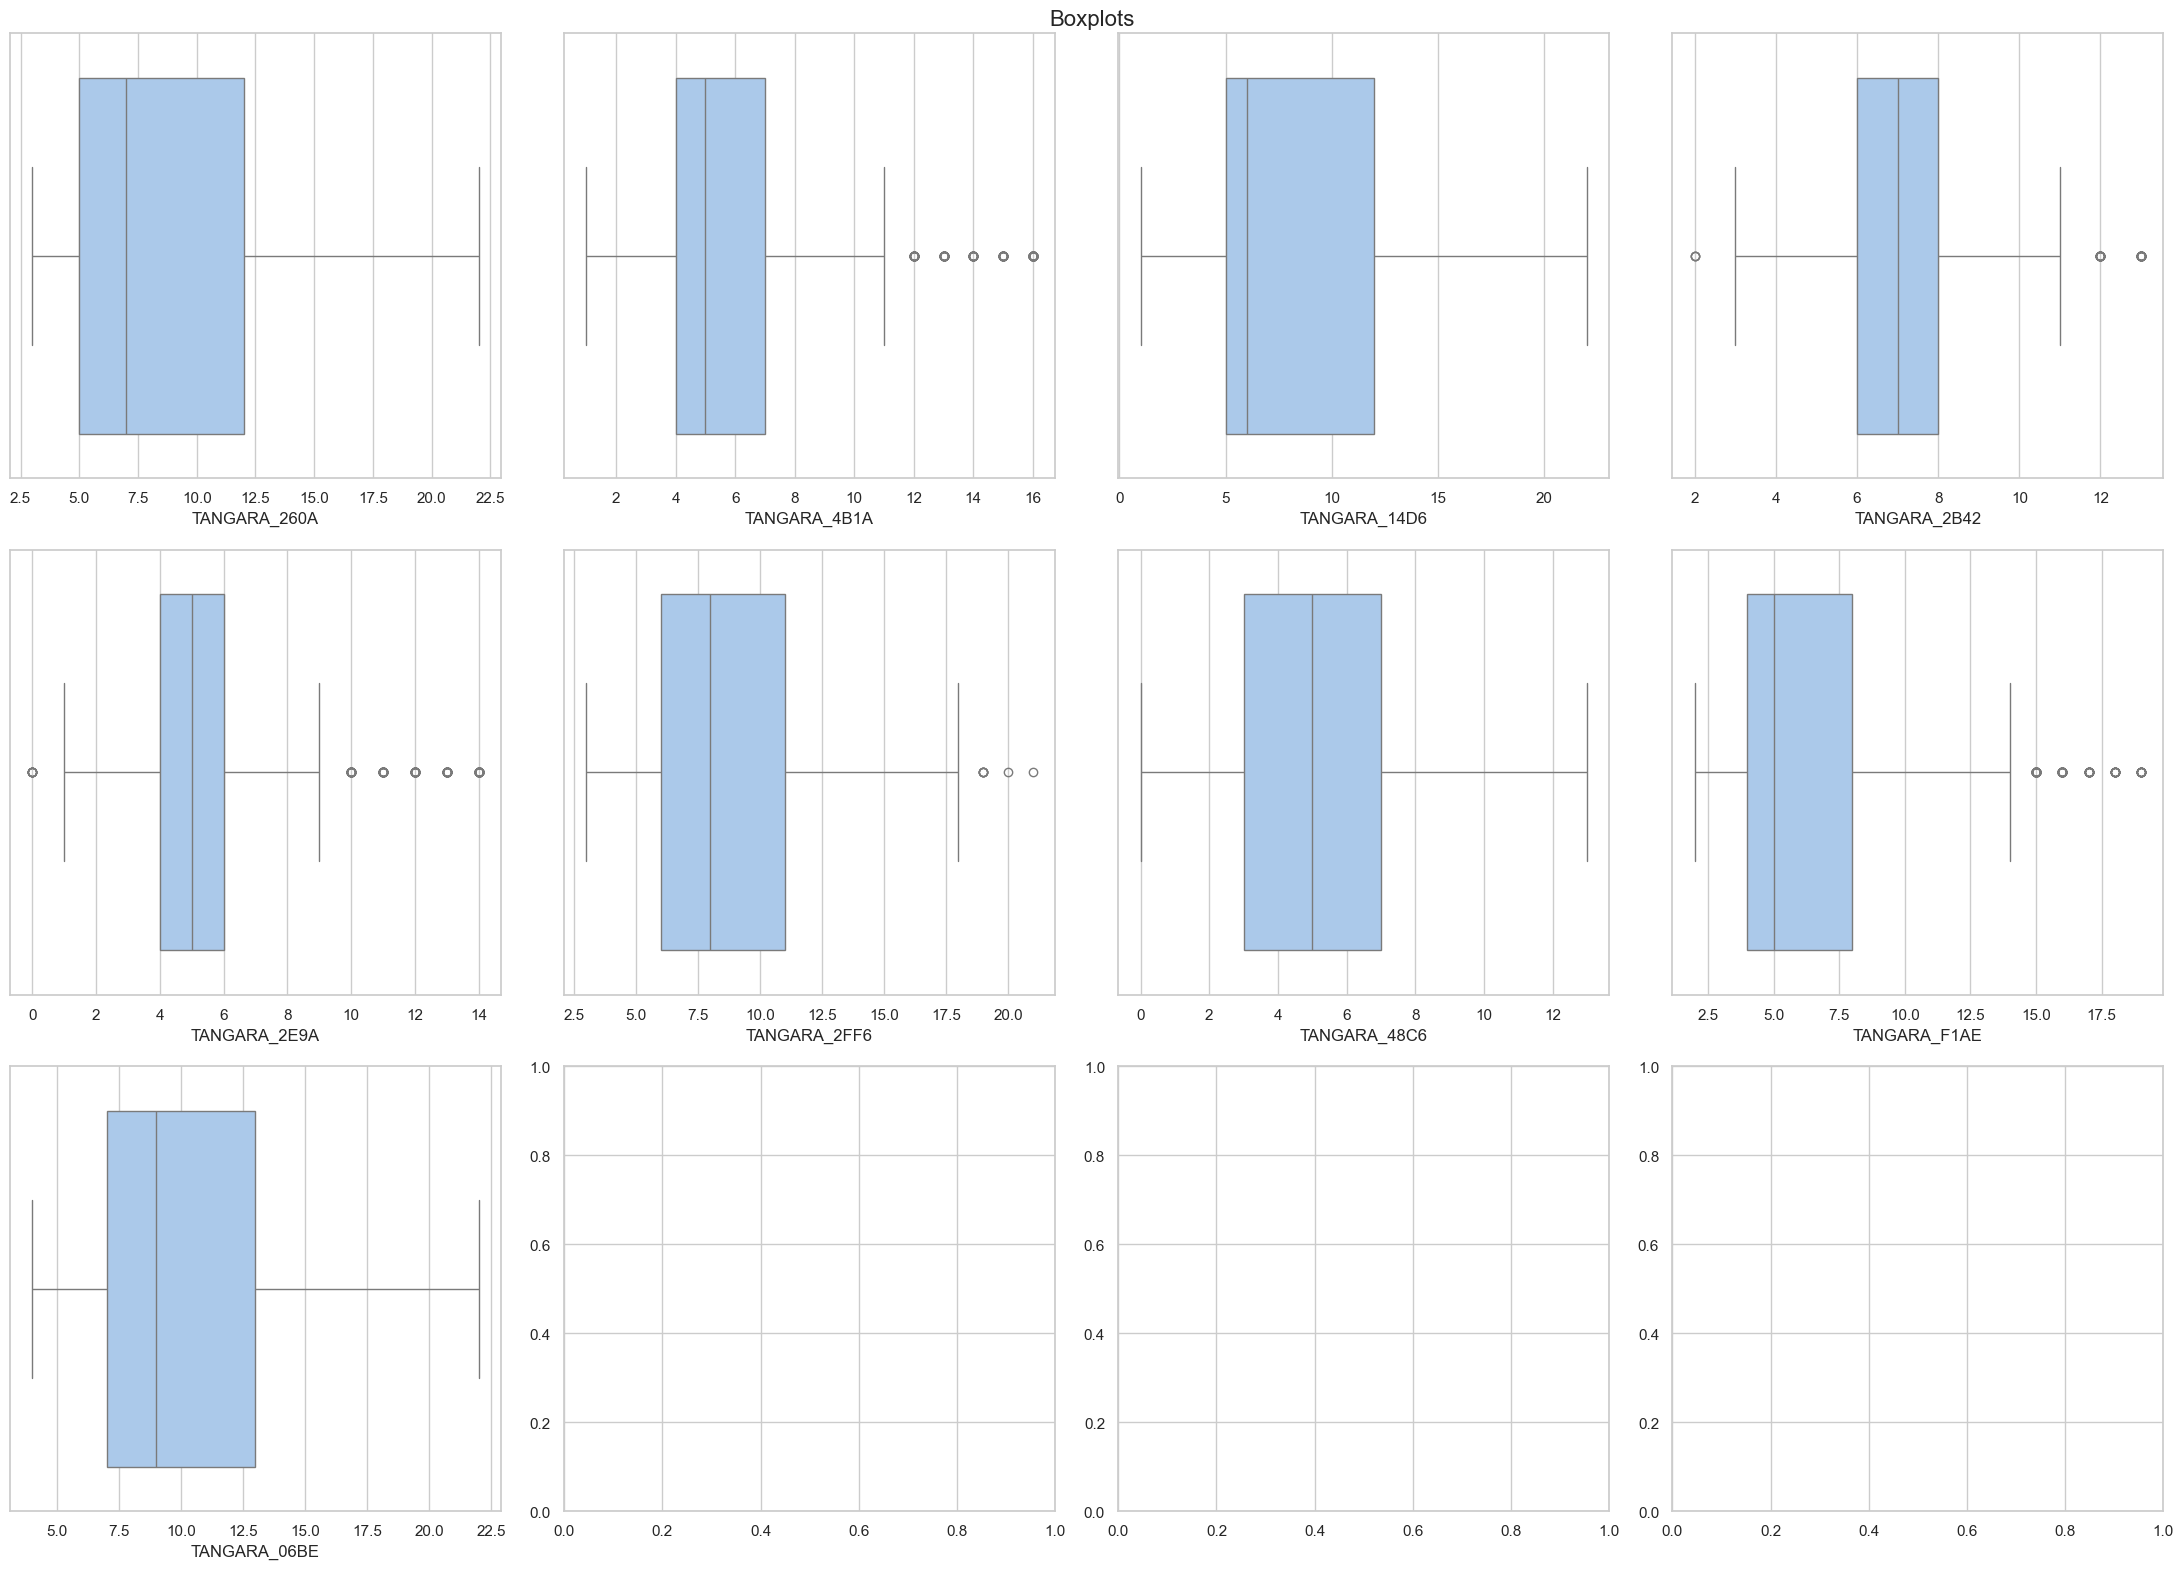

In [13]:
# Plot Boxplots
plot_boxes(df_pm25_clean)

## Lineplots

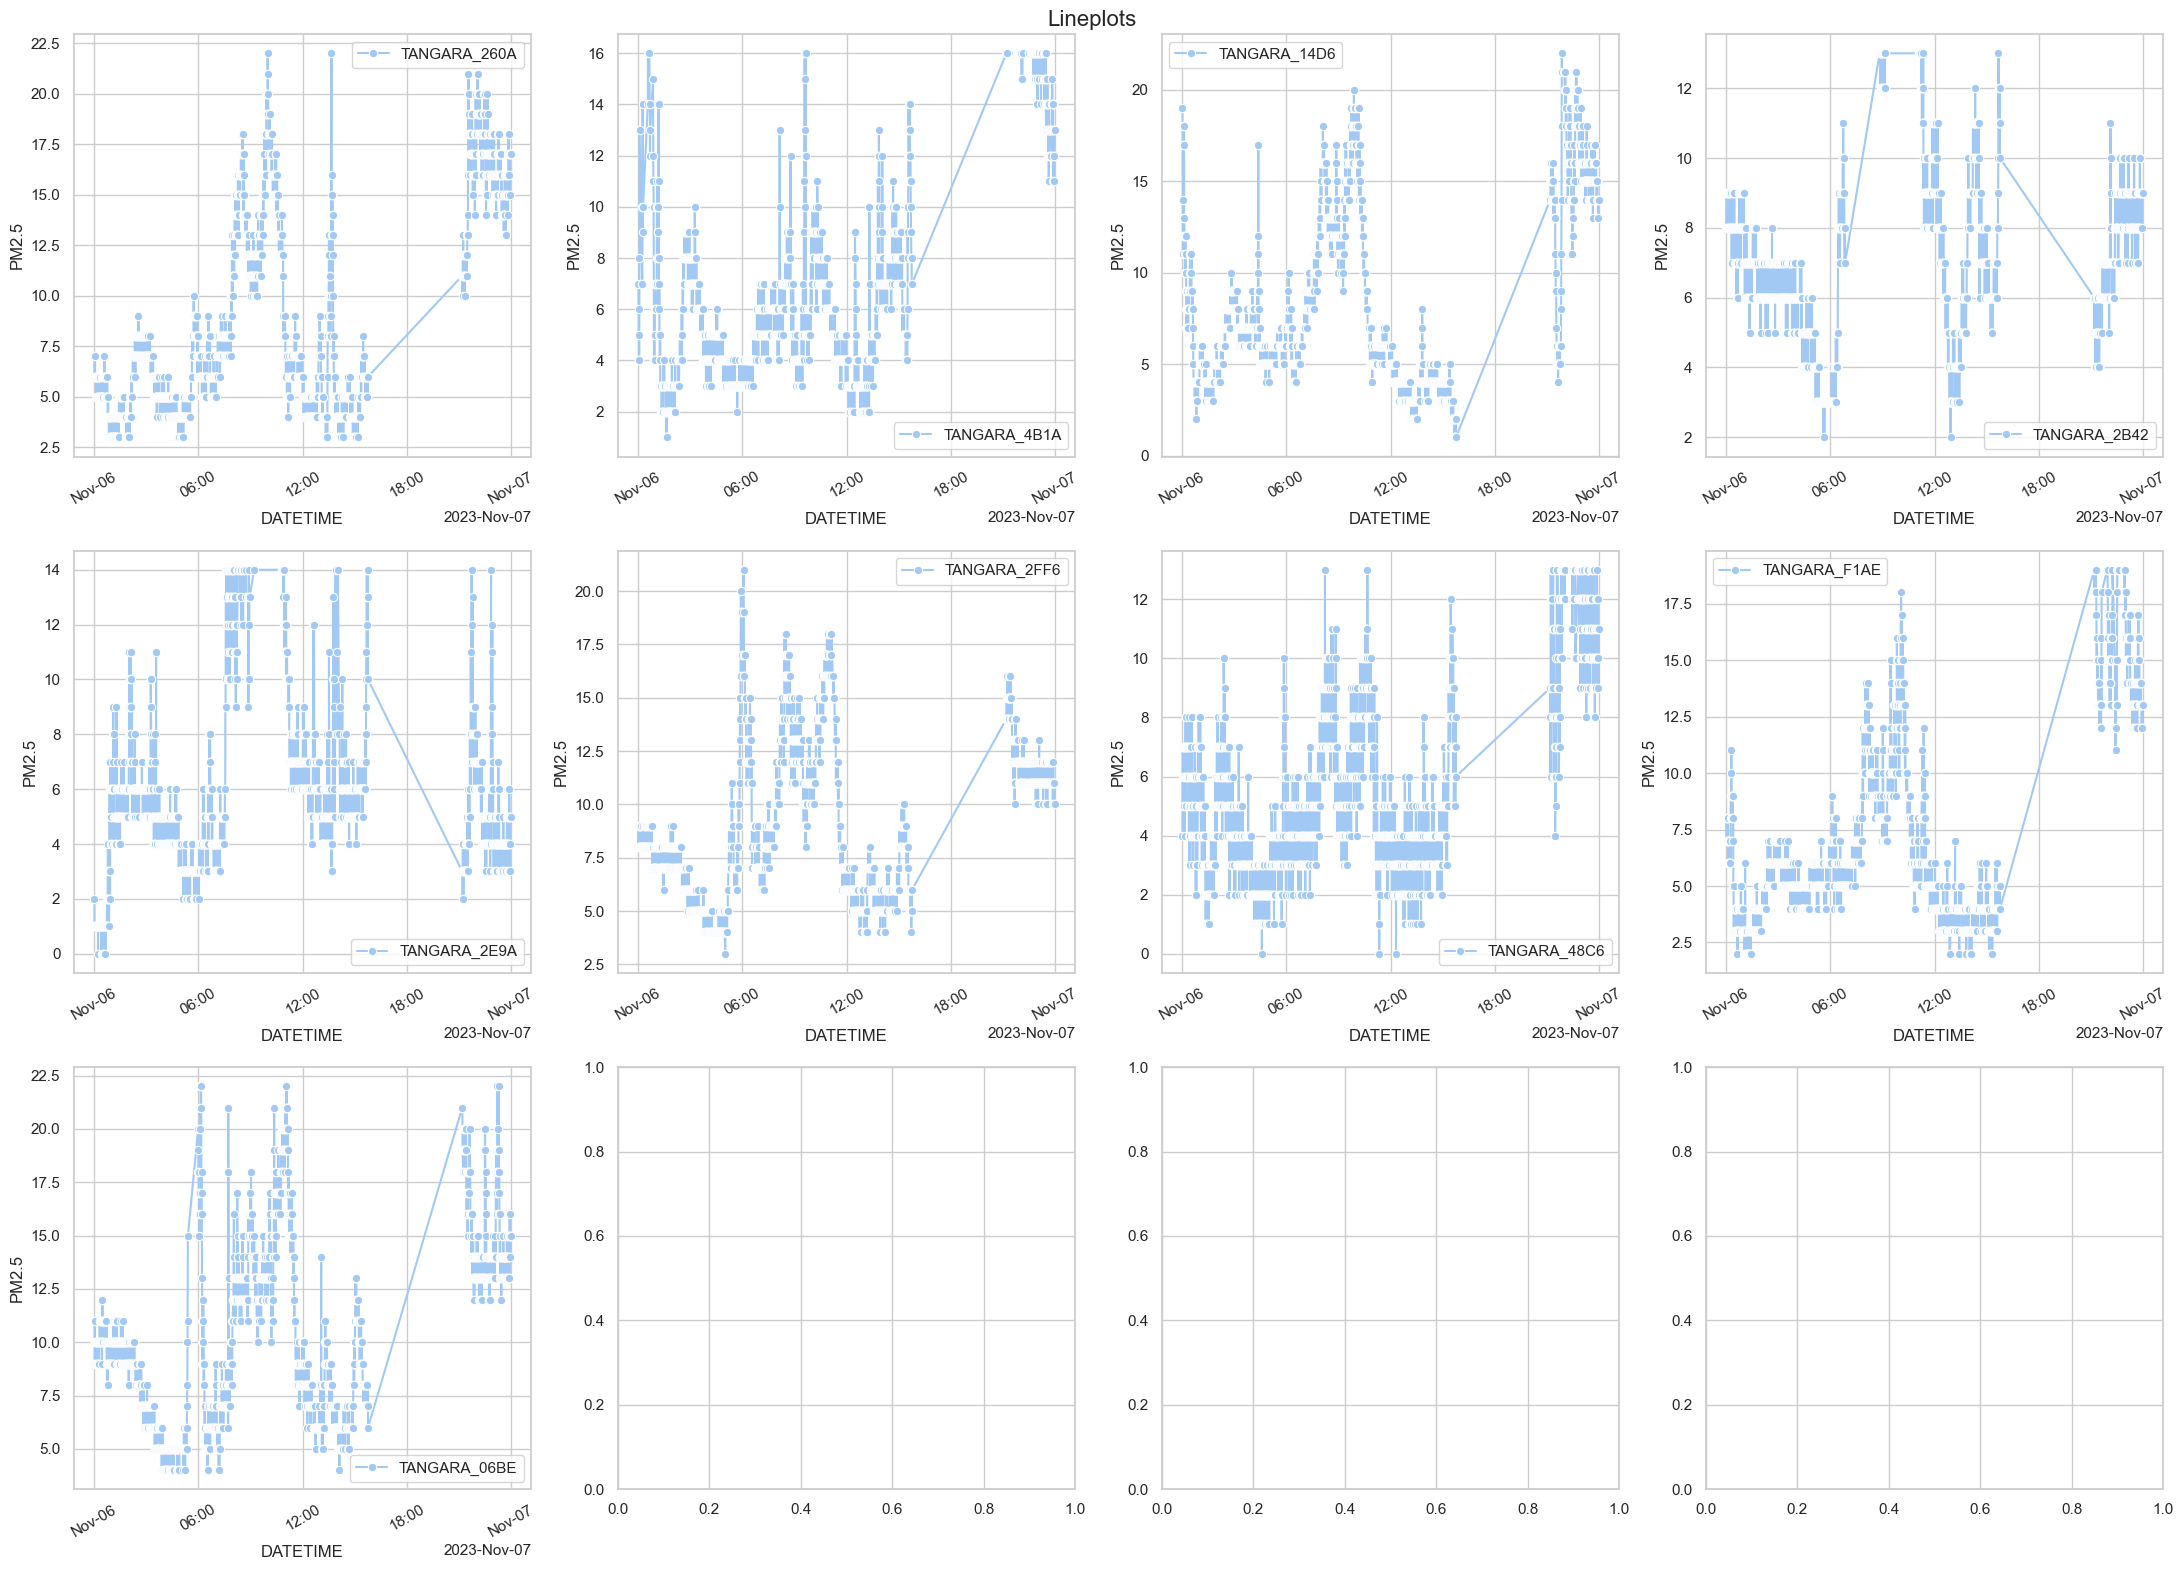

In [14]:
# Plot Lineplots
plot_lines(df_pm25_clean)

In [15]:
# Save PM2.5 Data Frame Sensors into CSV file
df_to_csv(df_pm25_clean, "pm25_clean.csv", datafolder='1_clean')